#  Trabajo Practico 2

    integrantes: Alvarez Vico Jazmín 
                 Cortés Conde Titó Javier
                 Frassia Fernando
                 

# Introducción

bla bla bla Martin Compuñoño



Funciones auxiliares

In [2]:
import scipy as sp
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import pylab
from scipy.signal import welch
import scipy.io
import os
from math import log
log2= lambda x:log(x,2)
from collections import defaultdict

def distribucion_normal(l1):
    return sp.stats.shapiro(l1)[1] >=0.05

def igual_varianza(l1,l2):
    estadistico = np.var(l1) / np.var(l2) 
    pval=  sp.stats.f.cdf(estadistico,len(l1)-1, len(l2)-1)
    #print("pval = " + str(pval))
    return pval>=0.05

def  wilcoxon_apareadas(l1,l2):
    pval= sp.stats.wilcoxon(l1,l2)[1]
    print("p value = " + str(pval))
    
def igual_media_apareada(l1,l2): 
    if distribucion_normal(l1) and distribucion_normal(l2):
        print("checkeo distribución normal: No concluyente, suponemos normalidad")
        ig_var = igual_varianza(l1,l2)
        ig_var2 = igual_varianza(l2,l1)
        if (ig_var and ig_var2):            
            print("checkeo varianza: No concluyente, suponemos igual varianza")
            print("utilizamos test de Student")
            pval = sp.stats.ttest_rel(l1, l2)[1]
            print("p value = " + str(pval) )
        else:
            print("checkeo varianza: NO")
            print("utilizamos test de Welsh")
            pval = sp.stats.ttest_ind(l1, l2)[1]
            print("p value = " + str(pval) )
            
    print("utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal")
    wilcoxon_apareadas(l1,l2)

def distribucion_normal(l1):
    return sp.stats.shapiro(l1)[1] >=0.05

def igual_media_1muestra(l):
    if distribucion_normal(l):
        print("checkeo distribución normal: ok") 
        meanl = np.mean(l)
        pval = sp.stats.ttest_1samp(l,meanl)[1]
        print("p value = " + str(pval) )
        

def promediar_epoch(sujeto, electrodo):
    df = pd.DataFrame(sujeto[:,electrodo-1,:])
    df_Media = df.mean(axis=0)
    return df_Media

def promediar_epoch_electrodo(sujeto):
    df8_Media = promediar_epoch(sujeto, 8)
    df44_Media = promediar_epoch(sujeto, 44)
    df80_Media = promediar_epoch(sujeto, 80)
    df131_Media = promediar_epoch(sujeto, 131)
    df185_Media = promediar_epoch(sujeto, 185)
    
    promedio_electrodos = (df8_Media + df44_Media + df80_Media + df131_Media + df185_Media)/5

    return promedio_electrodos 

def calcular_bandas(lista_sujetos, cantidad_electrodos, normalizado, index):
    #calculamos las potencias, ya que no utilizamos los valores generales.
    df_pot = pd.DataFrame()
    df_alphas = pd.DataFrame()
    df_betas = pd.DataFrame()
    df_thetas = pd.DataFrame()
    df_deltas = pd.DataFrame()
    df_gamas = pd.DataFrame()

    i=1
    for sujeto in lista_sujetos:

        potencias_media = []
        for count in range(cantidad_electrodos):
            welch = sp.signal.welch(sujeto[:,count,:], noverlap=100, fs=250)
            frecuencias = welch[0][:index]
            potencias = welch[1][:, :index]
            promedio_potencias = potencias.mean(axis=0)
            potencias_media.append(promedio_potencias)

        potencias_media = np.array(potencias_media)
        medias = potencias_media.mean(axis=0)

        index_delta = (np.abs(frecuencias-4)).argmin()
        delta = medias[:index_delta]
        df_deltas['sujeto'+str(i)] = delta

        index_theta = (np.abs(frecuencias-8)).argmin()
        theta= medias[index_delta+1:index_theta]
        df_thetas['sujeto'+str(i)] = theta

        index_alpha = (np.abs(frecuencias-13)).argmin()
        alpha = medias[index_theta+1:index_alpha]
        df_alphas['sujeto'+str(i)] = alpha

        index_beta = (np.abs(frecuencias-30)).argmin()
        beta = medias[index_alpha+1:index_beta]
        df_betas['sujeto'+str(i)] = beta

        gama = medias[index_beta+1:]
        df_gamas['sujeto'+str(i)] = gama
        i+=1
    if normalizado:
        df_pot['delta'] = df_deltas.sum() / len(df_deltas)
        df_pot['theta'] = df_thetas.sum() / len(df_thetas)
        df_pot['alpha'] = df_alphas.sum() / len(df_alphas)
        df_pot['beta'] = df_betas.sum() / len(df_betas)
        df_pot['gama'] = df_gamas.sum() / len(df_gamas)
    else:
        df_pot['delta'] = df_deltas.sum() 
        df_pot['theta'] = df_thetas.sum() 
        df_pot['alpha'] = df_alphas.sum() 
        df_pot['beta'] = df_betas.sum()
        df_pot['gama'] = df_gamas.sum()
    
    return df_pot

def tomar_banda(lista_sujetos, banda, index):
    df_alphas = pd.DataFrame()
    df_betas = pd.DataFrame()
    df_thetas = pd.DataFrame()
    df_deltas = pd.DataFrame()
    df_gamas = pd.DataFrame()

    i=1
    for sujeto in lista_sujetos:

        potencias_media = []
        for count in range(cantidad_electrodos):
            welch = sp.signal.welch(sujeto[:,count,:], noverlap=100, fs=250)
            frecuencias = welch[0][:index]
            potencias = welch[1][:, :index]
            promedio_potencias = potencias.mean(axis=0)
            potencias_media.append(promedio_potencias)

        potencias_media = np.array(potencias_media)
        medias = potencias_media.mean(axis=0)

        index_delta = (np.abs(frecuencias-4)).argmin()
        delta = medias[:index_delta]
        df_deltas['sujeto'+str(i)] = delta

        index_theta = (np.abs(frecuencias-8)).argmin()
        theta= medias[index_delta+1:index_theta]
        df_thetas['sujeto'+str(i)] = theta

        index_alpha = (np.abs(frecuencias-13)).argmin()
        alpha = medias[index_theta+1:index_alpha]
        df_alphas['sujeto'+str(i)] = alpha

        index_beta = (np.abs(frecuencias-30)).argmin()
        beta = medias[index_alpha+1:index_beta]
        df_betas['sujeto'+str(i)] = beta

        gama = medias[index_beta+1:]
        df_gamas['sujeto'+str(i)] = gama
        i+=1
    
    if banda == 'alpha':
        return df_alphas
    elif banda == 'gama':
        return df_gamas
    elif banda == 'delta':
        return df_deltas
    elif banda == 'beta':
        return df_betas
    elif banda == 'theta':
        return df_thetas
    else:
        print("escribiste mal la banda")

## Lectura de datos

los datos vienen en la forma de un tensor de tres dimensiones: epoch X Electrodo X serie temporal

In [3]:
lista_sujetosP = []
matrices = os.listdir('./matricesP/')
for mat in matrices:
    m = sp.io.loadmat('./matricesP/' + mat)
    mm = m['data']
    lista_sujetosP.append(mm)
    
       

lista_sujetosS = []
matrices = os.listdir('./matricesS/')
for mat in matrices:
    m = sp.io.loadmat('./matricesS/' + mat)
    mm = m['data']
    lista_sujetosS.append(mm)


Realizamos el promedio de las series temporales

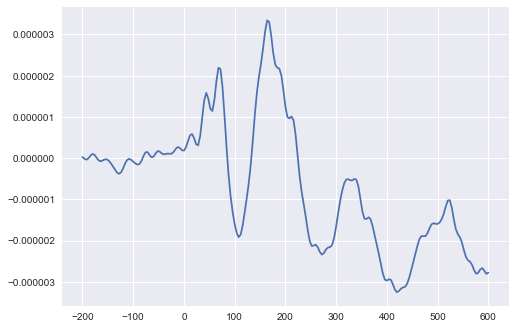

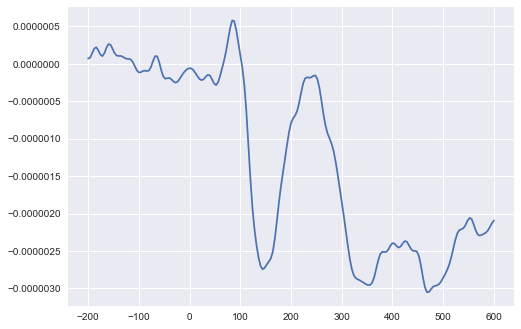

In [4]:
#promedio de serie temporal x epoch. (matriz de 1 epoch con la serie promediada.)
S_df8_Media = promediar_epoch(lista_sujetosS[0], 8)

plt.plot(np.linspace(-200, 600, 201), S_df8_Media)
plt.show()

P_df8_Media = promediar_epoch(lista_sujetosP[0], 8)
plt.plot(np.linspace(-200, 600, 201), P_df8_Media)
plt.show()

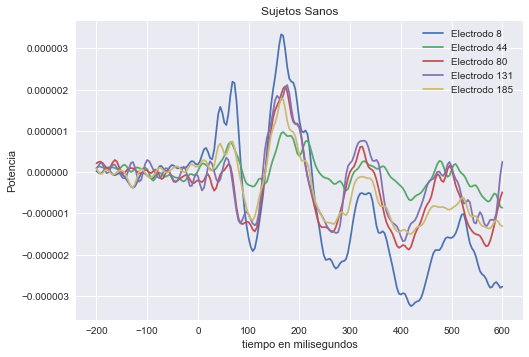

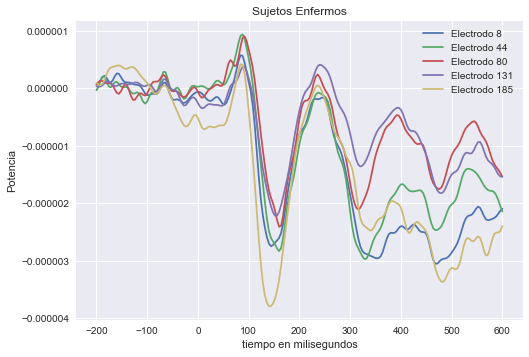

In [5]:

#epoch X serie temporal

sujetoS = lista_sujetosS[0]
S_df8_Media = promediar_epoch(sujetoS, 8)
S_df44_Media = promediar_epoch(sujetoS, 44)
S_df80_Media = promediar_epoch(sujetoS, 80)
S_df131_Media = promediar_epoch(sujetoS, 131)
S_df185_Media = promediar_epoch(sujetoS, 185)


sujetoP = lista_sujetosP[0]
P_df8_Media = promediar_epoch(sujetoP, 8)
P_df44_Media = promediar_epoch(sujetoP, 44)
P_df80_Media = promediar_epoch(sujetoP, 80)
P_df131_Media = promediar_epoch(sujetoP, 131)
P_df185_Media = promediar_epoch(sujetoP, 185)

S_elect8 = plt.plot(np.linspace(-200, 600, 201), S_df8_Media, label = "Electrodo 8")
S_elect44 = plt.plot(np.linspace(-200, 600, 201), S_df44_Media, label = "Electrodo 44")
S_elect80 = plt.plot(np.linspace(-200, 600, 201), S_df80_Media, label = "Electrodo 80")
S_elect131 = plt.plot(np.linspace(-200, 600, 201), S_df131_Media, label = "Electrodo 131")
S_elect185 = plt.plot(np.linspace(-200, 600, 201), S_df185_Media, label = "Electrodo 185")
plt.ylabel("Potencia")
plt.xlabel("tiempo en milisegundos")
plt.title("Sujetos Sanos")
plt.legend()
plt.show()

plt.plot(np.linspace(-200, 600, 201), P_df8_Media, label = "Electrodo 8")
plt.plot(np.linspace(-200, 600, 201), P_df44_Media, label = "Electrodo 44")
plt.plot(np.linspace(-200, 600, 201), P_df80_Media, label = "Electrodo 80")
plt.plot(np.linspace(-200, 600, 201), P_df131_Media, label = "Electrodo 131")
plt.plot(np.linspace(-200, 600, 201), P_df185_Media, label = "Electrodo 185")
plt.ylabel("Potencia")
plt.xlabel("tiempo en milisegundos")
plt.title("Sujetos Enfermos")
plt.legend()
plt.show()



# 2.1) Analisis de frecuencia



La frecuencia es una magnitud que mide el número de repeticiones por unidad de tiempo de cualquier fenómeno o suceso periódico. 
Es decir, podemos medir las ocurrencias de algun fenómeno utilizando el epoch y la serie temporal asociada al mismo. 


El espectrograma es una representación en tres dimensiones (temporal, frecuencial y amplitud) de la distribución de energía de una señal.
Podemos considerarlo como proyección bidimensional de estas tres dimensiones. En este caso representamos en el eje x los epochs (dimensión temporal), en el eje y la frecuencia (dimensión frecuencial) y con una escala de colores representamos la potencia (dimensión de amplitud).

Al realizar FFT, podemos extraer esta información de nuestros datos para mostrarla en el espectrograma.

En esta ocasión realizaremos el analisis de frecuencia para dos sujetos, uno en estado vegetativo, y el otro en condiciones normales.

a.1) Calcular la media entre los electrodos 8, 44, 80, 131 y 185 (el primer electrodo es el 0) y realizar una figura que muestre las frecuencias en el eje Y, los epochs en el eje X, y la potencia usando una escala de color.

In [6]:
S_elect8 = lista_sujetosS[0][:,7,:]
S_elect44 = lista_sujetosS[0][:,43,:]
S_elect80 = lista_sujetosS[0][:,79,:]
S_elect131 = lista_sujetosS[0][:,130,:]
S_elect185 = lista_sujetosS[0][:,184,:]

welch8 = sp.signal.welch(S_elect8, noverlap=100, fs=250)
index = (np.abs(welch8[0]-50)).argmin()
S_potencias8 = welch8[1][:, :index]

welch44 = sp.signal.welch(S_elect44, noverlap=100, fs=250)
S_potencias44 = welch44[1][:, :index]


welch80 = sp.signal.welch(S_elect80, noverlap=100, fs=250)
S_potencias80 = welch80[1][:, :index]

welch131 = sp.signal.welch(S_elect131, noverlap=100, fs=250)
S_potencias131 = welch131[1][:, :index]

welch185 = sp.signal.welch(S_elect185, noverlap=100, fs=250)
S_potencias185 = welch185[1][:, :index]

P_elect8 = lista_sujetosP[0][:,7,:]
P_elect44 = lista_sujetosP[0][:,43,:]
P_elect80 = lista_sujetosP[0][:,79,:]
P_elect131 = lista_sujetosP[0][:,130,:]
P_elect185 = lista_sujetosP[0][:,184,:]

welch8 = sp.signal.welch(P_elect8, noverlap=100, fs=250)
index = (np.abs(welch8[0]-50)).argmin()
P_potencias8 = welch8[1][:, :index]

welch44 = sp.signal.welch(P_elect44, noverlap=100, fs=250)
P_potencias44 = welch44[1][:, :index]


welch80 = sp.signal.welch(P_elect80, noverlap=100, fs=250)
P_potencias80 = welch80[1][:, :index]

welch131 = sp.signal.welch(P_elect131, noverlap=100, fs=250)
P_potencias131 = welch131[1][:, :index]

welch185 = sp.signal.welch(P_elect185, noverlap=100, fs=250)
P_potencias185 = welch185[1][:, :index]


/home/javier/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


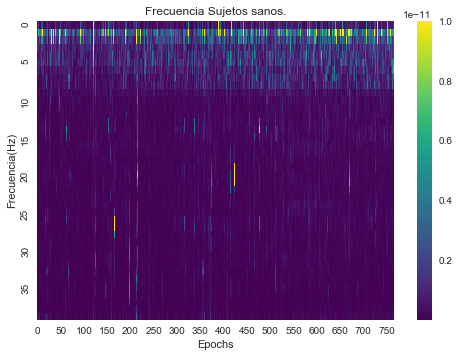

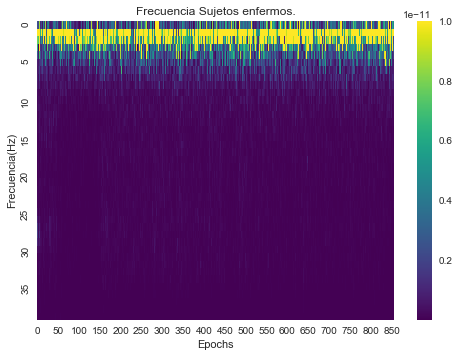

In [7]:
S_promedio_potencias= (S_potencias8 + S_potencias44 + S_potencias80 + S_potencias131 + S_potencias185 )/5
sn.heatmap(np.transpose(S_promedio_potencias), cmap='viridis', vmax=1e-11,  xticklabels = 50, yticklabels=5)
plt.title("Frecuencia Sujetos sanos.")
plt.ylabel("Frecuencia(Hz)")
plt.xlabel("Epochs")
plt.show()

P_promedio_potencias= (P_potencias8 + P_potencias44 + P_potencias80 + P_potencias131 + P_potencias185 )/5
sn.heatmap(np.transpose(P_promedio_potencias), cmap='viridis', vmax=1e-11, xticklabels = 50, yticklabels = 5)
plt.ylabel("Frecuencia(Hz)")
plt.xlabel("Epochs")
plt.title("Frecuencia Sujetos enfermos.")
plt.show()

Para poder comparar entre ambas potencias, decidimos restar los valores del sujeto sano y el enfermo(se acorto la dimensión del sujeto enfermo, ya que tenía más epochs que el sujeto sano). Se calcula el valor absoluto ya que al no tomarlo, el espectro no dejaba ver una diferencia clara entre sujetos, Esto tiene una clara desventaja por que no sabemos cual tiene más o menos potencia en un punto.  

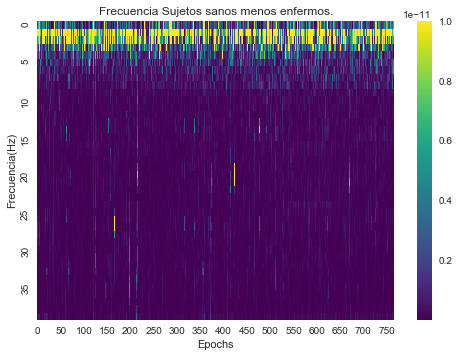

In [8]:
minimo_epochs = min(P_promedio_potencias.shape[0], S_promedio_potencias.shape[0])

P_promedio_potencias = P_promedio_potencias[:minimo_epochs,:]
S_promedio_potencias = S_promedio_potencias[:minimo_epochs,:]
S_P_prom = np.absolute(P_promedio_potencias - S_promedio_potencias);
sn.heatmap(np.transpose(S_P_prom), cmap='viridis',vmax = 1e-11, xticklabels = 50, yticklabels = 5)
plt.ylabel("Frecuencia(Hz)")
plt.xlabel("Epochs")
plt.title("Frecuencia Sujetos sanos menos enfermos.")
plt.show()

Otra forma de mostrar este información es a travez de un gráfico de linea.
En el mismo se representa cada epoch con una linea, en el eje X representamos la frecuencia  y en el Y el promedio de las potencias para ese epoch

40


/home/javier/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


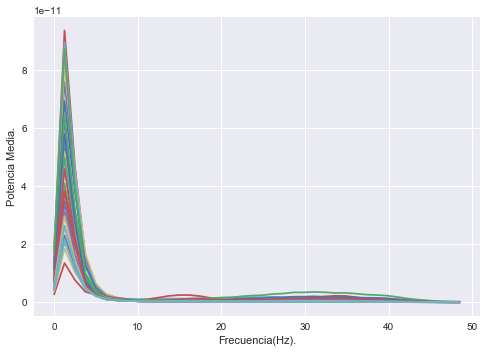

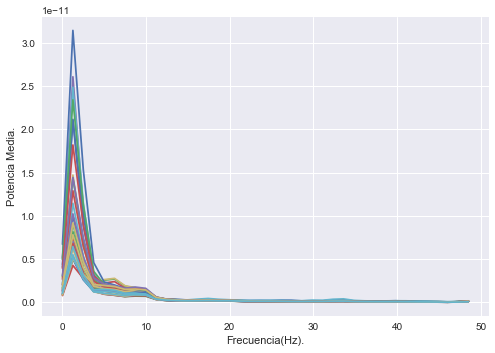

In [9]:
#promedio de potencias de frecuencias por epoch
print(index)
P_potencias_media = []
for count in range(30):
    welch = sp.signal.welch(lista_sujetosP[0][:,count,:], noverlap=100, fs=250)
    frecuencias = welch[0][:index]
    potencias = welch[1][:, :index]
    promedio_potencias = potencias.mean(axis=0)
    P_potencias_media.append(promedio_potencias)
    plt.plot(frecuencias, np.transpose(promedio_potencias))

plt.xlabel("Frecuencia(Hz).")
plt.ylabel("Potencia Media.")
#plt.title("Frecuencia Sujetos sanos menos enfermos.")
plt.show()


S_potencias_media = []
for count in range(30):
    welch = sp.signal.welch(lista_sujetosS[0][:,count,:], noverlap=100, fs=250)
    frecuencias = welch[0][:index]
    potencias = welch[1][:, :index]
    promedio_potencias = potencias.mean(axis=0)
    S_potencias_media.append(promedio_potencias)
    plt.plot(frecuencias, np.transpose(promedio_potencias))

plt.ylabel("Potencia Media.")
plt.xlabel("Frecuencia(Hz).")
#plt.title("Frecuencia Sujetos sanos menos enfermos.")
plt.show()



#hacer este grafico para los otros electrodos y plotear en el mismo grafico + belleza

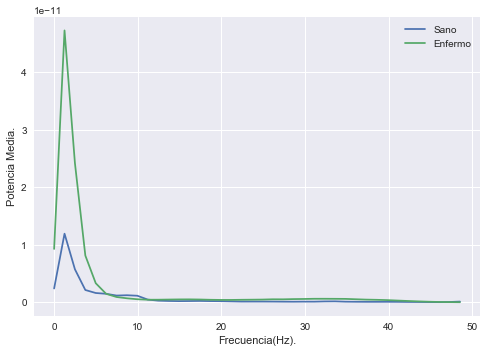

In [10]:
#print(potencias_media[1,:])

P_potencias_media = np.array(P_potencias_media)
P_medias = P_potencias_media.mean(axis=0)

S_potencias_media = np.array(S_potencias_media)
S_medias = S_potencias_media.mean(axis=0)


plt.plot(frecuencias, S_medias, label = "Sano")
plt.plot(frecuencias, P_medias, label = "Enfermo")
plt.legend()
plt.ylabel("Potencia Media.")
plt.xlabel("Frecuencia(Hz).")
#plt.title("Frecuencia.")
plt.show()   
        
        
    

# b) Calcular los valores de cada banda de frecuencia, promediados entre los electrodos (todos) y epochs para cada sujeto.

In [11]:
#Para los sujetos enfermos
#cuantos electrodos queremos tener en cuenta /se podria pasar una lista con electrodos pre selecionados
cantidad_electrodos = 30
P_pot = calcular_bandas(lista_sujetosP, cantidad_electrodos, False, index)
print(P_pot)


/home/javier/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


                delta         theta         alpha          beta          gama
sujeto1  8.073636e-11  4.801059e-12  1.689331e-12  6.292932e-12  5.235659e-12
sujeto2  7.885791e-11  5.653144e-12  1.467587e-12  1.000948e-12  3.548564e-13
sujeto3  5.208324e-11  5.937788e-12  1.817280e-12  9.990306e-13  3.381059e-13
sujeto4  5.137965e-11  4.062093e-12  1.350846e-12  1.934666e-12  1.026047e-12
sujeto5  5.851673e-11  1.668007e-11  1.485093e-12  3.334227e-12  1.647675e-12
sujeto6  4.949784e-11  9.752007e-12  1.652113e-12  2.059002e-12  1.043252e-12
sujeto7  6.055293e-11  1.824816e-11  3.423034e-12  3.961061e-12  1.858157e-12
sujeto8  6.297806e-11  4.481956e-12  2.233026e-12  1.381979e-12  2.987897e-13


In [12]:
#Para los sujetos sanos
S_pot = calcular_bandas(lista_sujetosS, cantidad_electrodos, False, index)
print(S_pot)

/home/javier/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


                delta         theta         alpha          beta          gama
sujeto1  2.008125e-11  3.106035e-12  2.856542e-12  2.246954e-12  1.409650e-12
sujeto2  3.828608e-11  2.423998e-12  1.659783e-11  4.067588e-12  1.584480e-12
sujeto3  1.615492e-11  5.901515e-12  9.695468e-12  3.428125e-12  5.189102e-13
sujeto4  1.694187e-11  2.237660e-12  2.268376e-12  3.882148e-12  2.471544e-12
sujeto5  5.897101e-11  2.533486e-11  3.023585e-11  3.228240e-11  2.288836e-11
sujeto6  2.873541e-11  3.553410e-12  2.426252e-11  3.083918e-12  1.048510e-12
sujeto7  3.011972e-11  2.231760e-12  1.071120e-11  6.019996e-12  3.794738e-12
sujeto8  1.745363e-11  2.311720e-12  1.711761e-11  2.603746e-12  3.642118e-13
sujeto9  1.591073e-11  2.497207e-12  2.179856e-11  3.660682e-12  1.010291e-12


# Categorico

c) Tomar la potencia de cada sujeto en la banda Alpha y graficar cada uno de los graficos categóricos de seaborn.

Suejtos sanos: 


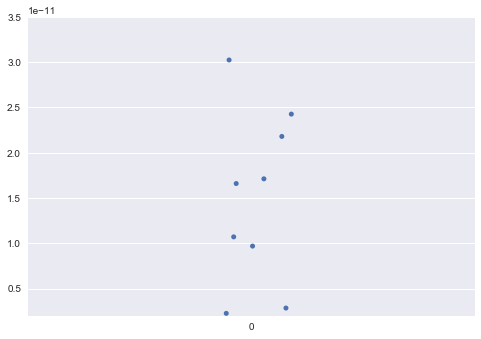

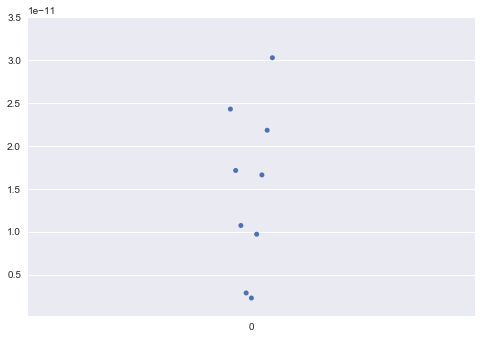

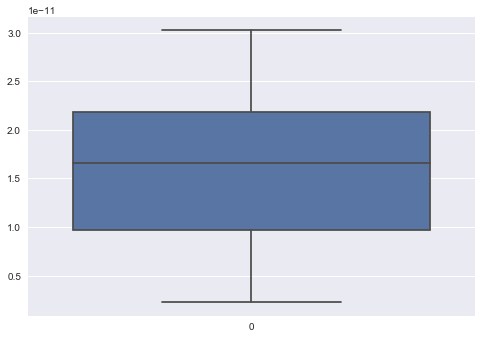

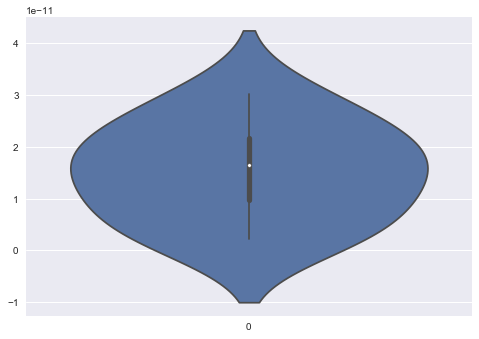

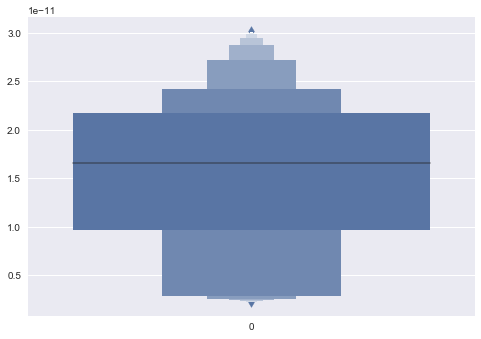

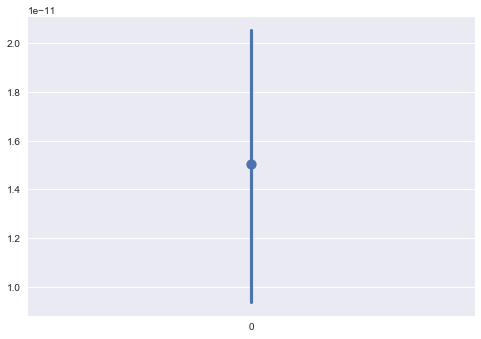

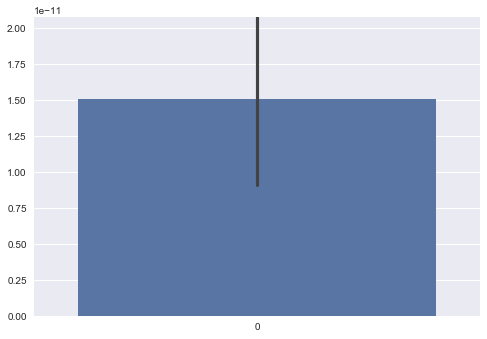

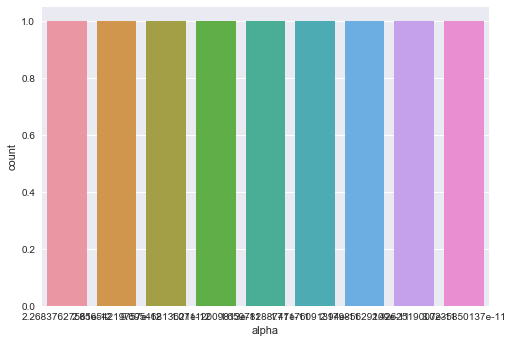

In [13]:

print('Suejtos sanos: ')
sn.stripplot(data=S_pot['alpha'], jitter = True, vmin = 5e-13, vmax =2e-11)
#sn.stripplot(data=df_P_alpha, jitter = True)
plt.ylim(2e-12, 3.5e-11)
plt.show()
sn.swarmplot(data=S_pot['alpha'])
plt.ylim(2e-13, 3.5e-11)
plt.show()
sn.boxplot(data=S_pot['alpha']) 
plt.show()
sn.violinplot(data=S_pot['alpha'])
plt.show()
sn.lvplot(data=S_pot['alpha'])
plt.show()
sn.pointplot(data=S_pot['alpha'])
plt.show()
sn.barplot(data=S_pot['alpha'])
plt.show()
sn.countplot(x=[i for i in range(len(S_pot['alpha']))] ,data=S_pot['alpha'])

plt.show()
print('')

Sujetos enfermos: 


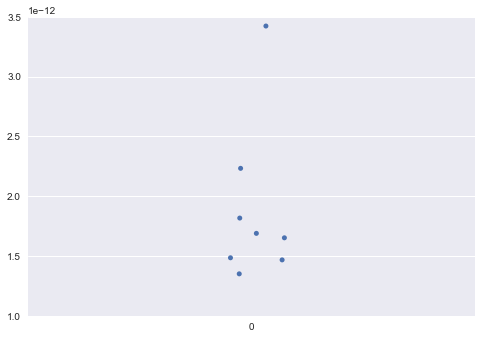

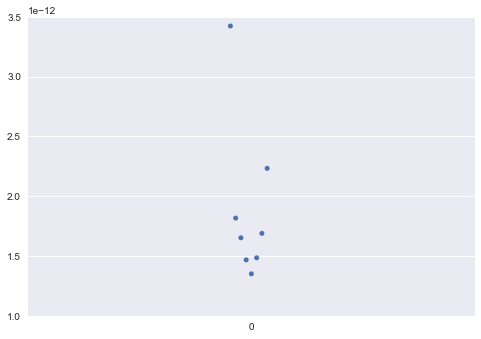

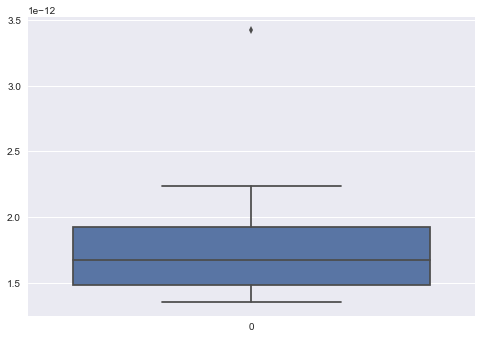

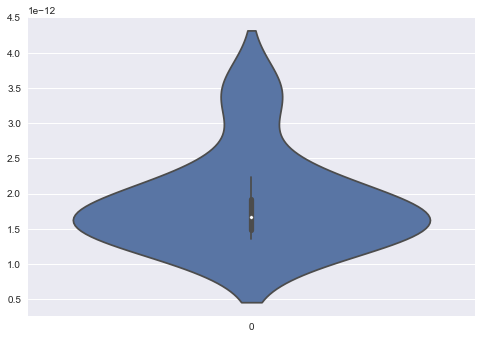

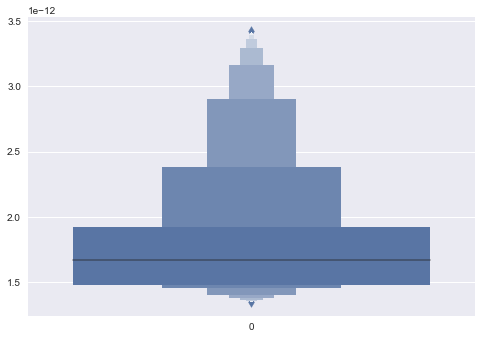

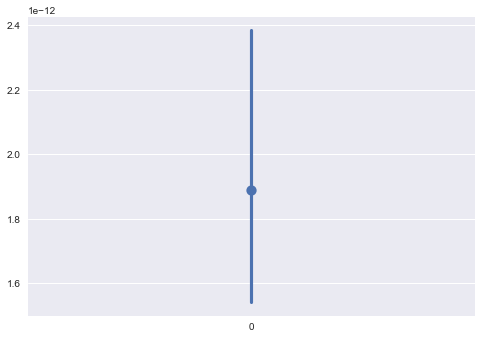

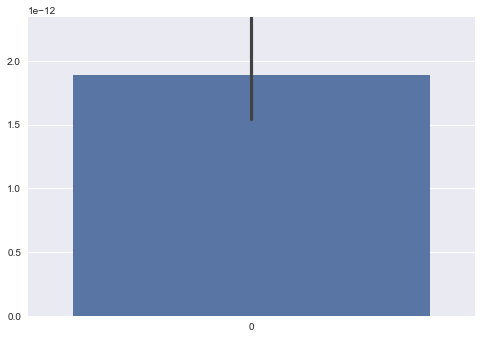

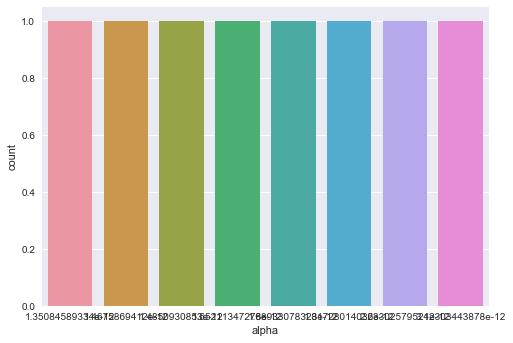

In [14]:

print('Sujetos enfermos: ')
sn.stripplot(data=P_pot['alpha'], jitter = True, vmin = 5e-13, vmax =2e-11)
#sn.stripplot(data=df_P_alpha, jitter = True)
plt.ylim(1e-12, 3.5e-12)
plt.show()
sn.swarmplot(data=P_pot['alpha'])
plt.ylim(1e-12, 3.5e-12)
plt.show()
sn.boxplot(data=P_pot['alpha']) 
plt.show()
sn.violinplot(data=P_pot['alpha'])
plt.show()
sn.lvplot(data=P_pot['alpha'])
plt.show()
sn.pointplot(data=P_pot['alpha'])
plt.show()
sn.barplot(data=P_pot['alpha'])
plt.show()
sn.countplot(x=[i for i in range(len(P_pot['alpha']))] ,data=P_pot['alpha'])

plt.show()
print('')

¿Cuál recomendaría para graficar y comparar distribuciones?

violin plot, ya que no solo nos muestra donde estan los quartiles y si hay algún outlier, como lo hace el box plot, sino que tambien nos muestra como estan distribuidos los puntos. Es decir, las partes mas anchas tienen mayor dencidad de puntos y las mas angostas tienen menos punto. Esto nos deja observar mucho mejor el espacio de muestra y como se distribuye en el espacio.

# d) Para cada banda de frecuencia, graficar según lo elegido en el punto c) y realizar un test estadístico apropiado.

## Pacientes P

violin plot para todas las bandas


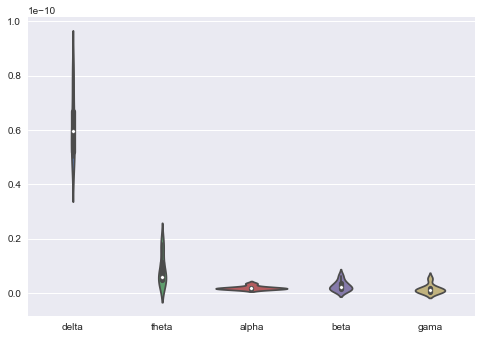

violin plot para alpha


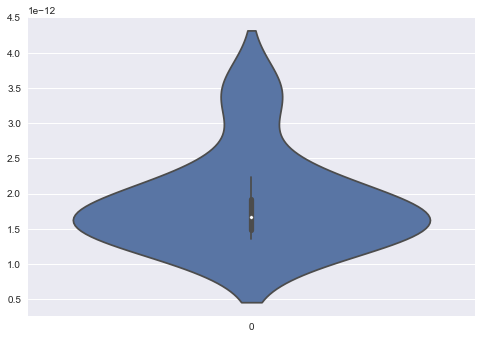

violin plot para beta


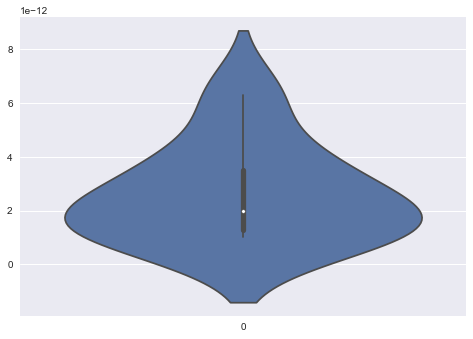

violin plot para theta


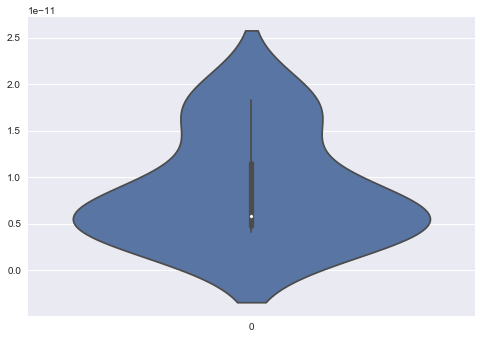

violin plot para delta


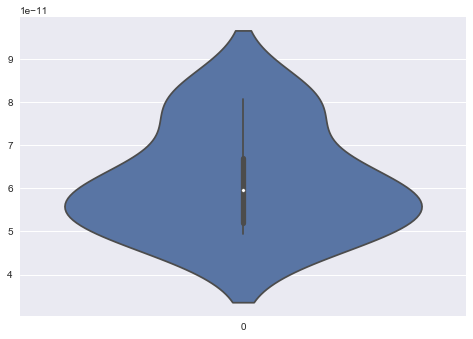

violin plot para gama


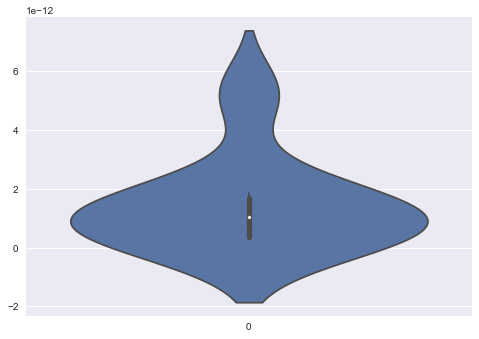

In [15]:
print('violin plot para todas las bandas')
sn.violinplot(data=P_pot)
plt.show()
print('violin plot para alpha')
sn.violinplot(data=P_pot['alpha'])
plt.show()

print('violin plot para beta')
sn.violinplot(data=P_pot['beta'])
plt.show()
#igual_media_1muestra(beta)

print('violin plot para theta')    
sn.violinplot(data=P_pot['theta'])
plt.show()
#print("muy pocos datos para llegar a una conclusión")
#igual_media_1muestra(theta)
    
print('violin plot para delta')    
sn.violinplot(data=P_pot['delta'])
plt.show()
#igual_media_1muestra(delta)
 
print('violin plot para gama')
sn.violinplot(data=P_pot['gama'])
plt.show()

## Pacientes S

violin plot para todas las bandas


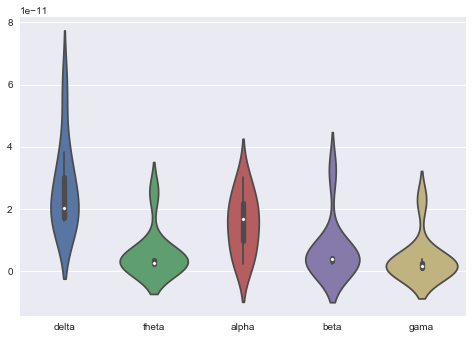

violin plot para alpha


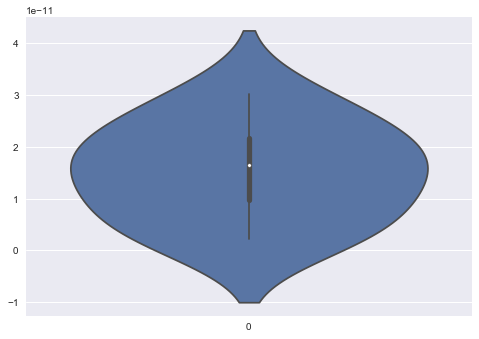

violin plot para beta


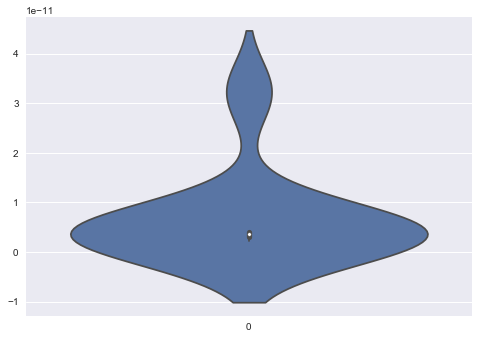

violin plot para theta


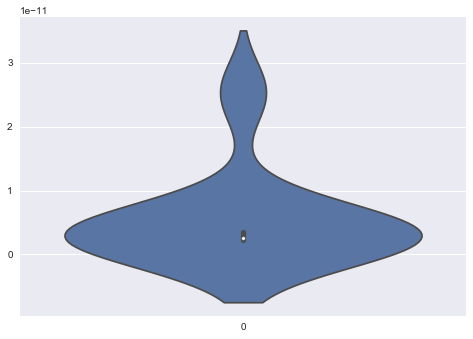

violin plot para delta


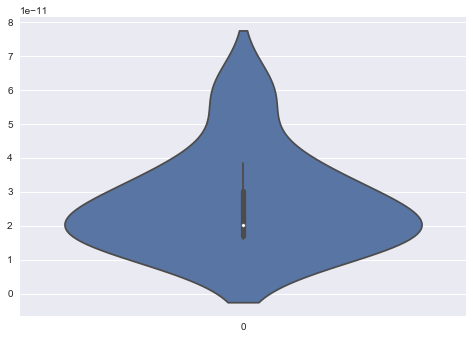

violin plot para gama


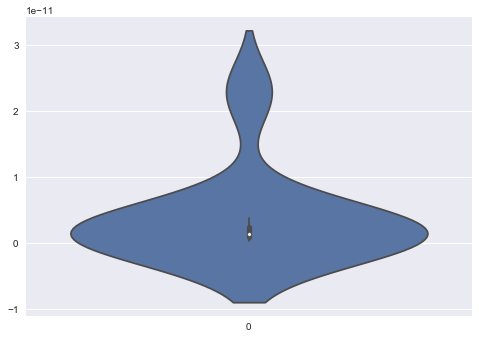

In [16]:
print('violin plot para todas las bandas')
sn.violinplot(data=S_pot)
plt.show()

print('violin plot para alpha')
sn.violinplot(data=S_pot['alpha'])
plt.show()

print('violin plot para beta')
sn.violinplot(data=S_pot['beta'])
plt.show()
#igual_media_1muestra(beta)

print('violin plot para theta')    
sn.violinplot(data=S_pot['theta'])
plt.show()
#print("muy pocos datos para llegar a una conclusión")
#igual_media_1muestra(theta)
    
print('violin plot para delta')    
sn.violinplot(data=S_pot['delta'])
plt.show()
#igual_media_1muestra(delta)
 
print('violin plot para gama')
sn.violinplot(data=S_pot['gama'])
plt.show()

## Test Estadístico d)

#### Idea: Tomamos la banda gamma y queremos ver si dos pacientes tienen la misma media. la banda gama por cada paciente es e l promedio de todos sus epochs.

In [18]:
gama = tomar_banda(lista_sujetosS, 'gama', index)

igual_media_apareada(gama['sujeto1'],gama['sujeto2'])

/home/javier/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


checkeo distribución normal: No concluyente, suponemos normalidad
checkeo varianza: No concluyente, suponemos igual varianza
utilizamos test de Student
p value = 0.250153985307
utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal
p value = 0.191446403571


No podemos concluir nada ya que nuestro p valor no fue lo suficientemente chico.

# e) Repetir los puntos b) y d) para los valores normalizados.

## Pacientes Enfermos

In [23]:

#Para los sujetos enfermos
cantidad_electrodos = 30
P_pot = calcular_bandas(lista_sujetosP, cantidad_electrodos, True, index)

print(P_pot)




/home/javier/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


                delta         theta         alpha          beta          gama
sujeto1  2.691212e-11  2.400529e-12  5.631103e-13  4.840717e-13  3.490439e-13
sujeto2  2.628597e-11  2.826572e-12  4.891956e-13  7.699603e-14  2.365710e-14
sujeto3  1.736108e-11  2.968894e-12  6.057600e-13  7.684851e-14  2.254039e-14
sujeto4  1.712655e-11  2.031046e-12  4.502820e-13  1.488205e-13  6.840312e-14
sujeto5  1.950558e-11  8.340033e-12  4.950310e-13  2.564790e-13  1.098450e-13
sujeto6  1.649928e-11  4.876003e-12  5.507045e-13  1.583847e-13  6.955014e-14
sujeto7  2.018431e-11  9.124081e-12  1.141011e-12  3.046970e-13  1.238772e-13
sujeto8  2.099269e-11  2.240978e-12  7.443419e-13  1.063061e-13  1.991931e-14


violin plot para todas las bandas


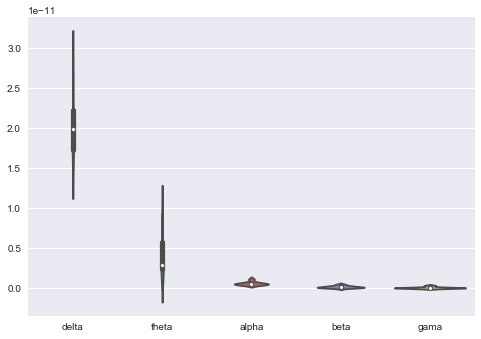

violin plot para alpha


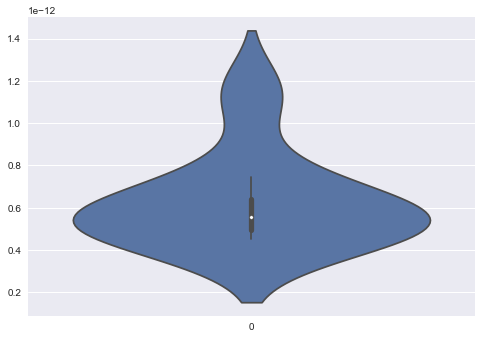

violin plot para beta


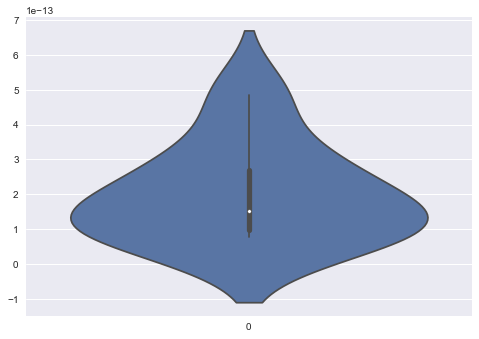

violin plot para theta


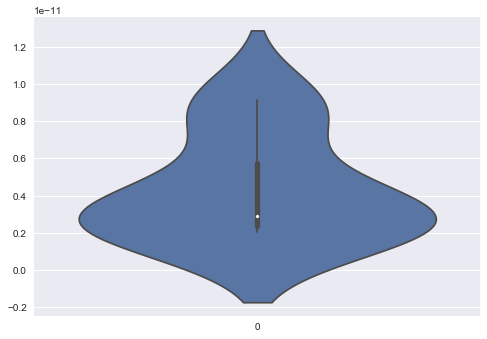

violin plot para delta


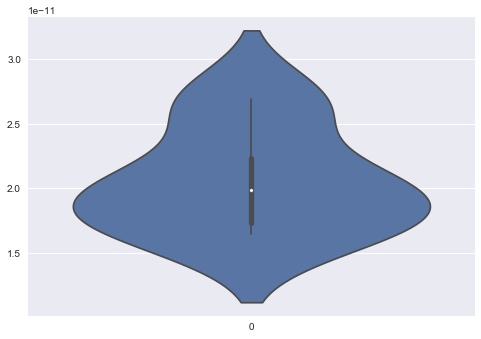

violin plot para gama


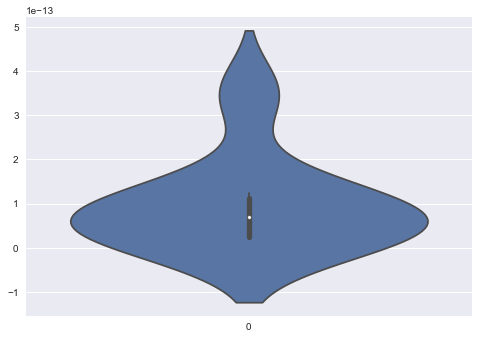

In [22]:
print('violin plot para todas las bandas')
sn.violinplot(data=P_pot)
plt.show()
print('violin plot para alpha')
sn.violinplot(data=P_pot['alpha'])
plt.show()

print('violin plot para beta')
sn.violinplot(data=P_pot['beta'])
plt.show()
#igual_media_1muestra(beta)

print('violin plot para theta')    
sn.violinplot(data=P_pot['theta'])
plt.show()
#print("muy pocos datos para llegar a una conclusión")
#igual_media_1muestra(theta)
    
print('violin plot para delta')    
sn.violinplot(data=P_pot['delta'])
plt.show()
#igual_media_1muestra(delta)
 
print('violin plot para gama')
sn.violinplot(data=P_pot['gama'])
plt.show()

### Test estadístico

In [27]:

igual_media_apareada(P_pot['beta'],P_pot['gama'])

utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal
p value = 0.0117186855998


/home/javier/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Podemos observar que el test de Wilcoxon nos da un pvalor muy bajo rechazando la hipótesis nula es decir que beta y alpha no tienen la misma media.

## Pacientes sanos

In [24]:
#Para los sujetos sanos
S_pot = calcular_bandas(lista_sujetosS, cantidad_electrodos, False, index)

print(S_pot)

/home/javier/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


                delta         theta         alpha          beta          gama
sujeto1  2.008125e-11  3.106035e-12  2.856542e-12  2.246954e-12  1.409650e-12
sujeto2  3.828608e-11  2.423998e-12  1.659783e-11  4.067588e-12  1.584480e-12
sujeto3  1.615492e-11  5.901515e-12  9.695468e-12  3.428125e-12  5.189102e-13
sujeto4  1.694187e-11  2.237660e-12  2.268376e-12  3.882148e-12  2.471544e-12
sujeto5  5.897101e-11  2.533486e-11  3.023585e-11  3.228240e-11  2.288836e-11
sujeto6  2.873541e-11  3.553410e-12  2.426252e-11  3.083918e-12  1.048510e-12
sujeto7  3.011972e-11  2.231760e-12  1.071120e-11  6.019996e-12  3.794738e-12
sujeto8  1.745363e-11  2.311720e-12  1.711761e-11  2.603746e-12  3.642118e-13
sujeto9  1.591073e-11  2.497207e-12  2.179856e-11  3.660682e-12  1.010291e-12


violin plot para todas las bandas


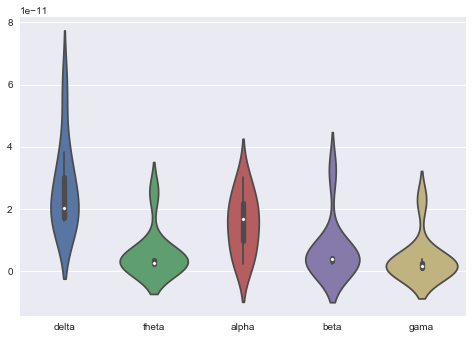

violin plot para alpha


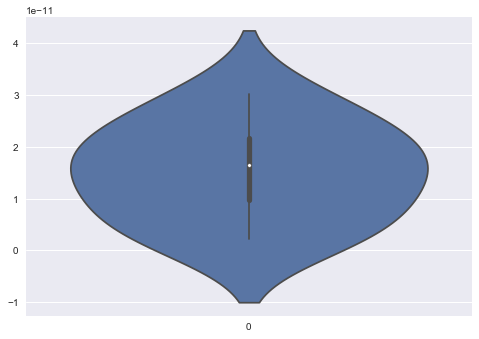

violin plot para beta


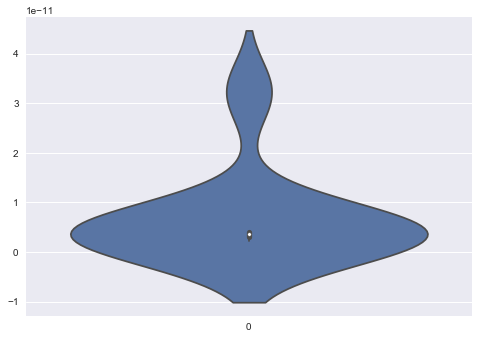

violin plot para theta


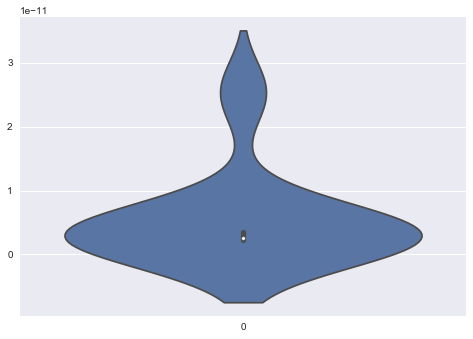

violin plot para delta


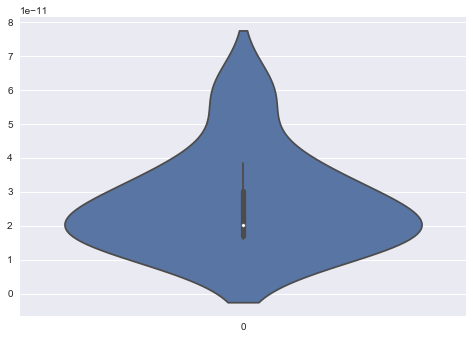

violin plot para gama


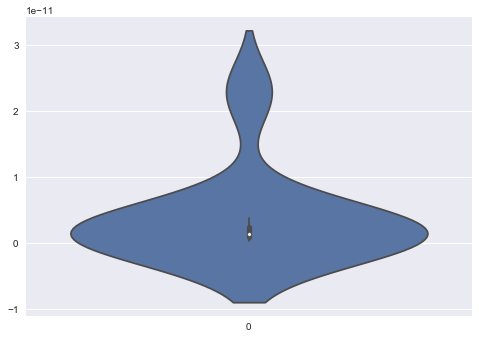

In [25]:

print('violin plot para todas las bandas')
sn.violinplot(data=S_pot)
plt.show()
print('violin plot para alpha')
sn.violinplot(data=S_pot['alpha'])
plt.show()

print('violin plot para beta')
sn.violinplot(data=S_pot['beta'])
plt.show()
#igual_media_1muestra(beta)

print('violin plot para theta')    
sn.violinplot(data=S_pot['theta'])
plt.show()
#print("muy pocos datos para llegar a una conclusión")
#igual_media_1muestra(theta)
    
print('violin plot para delta')    
sn.violinplot(data=S_pot['delta'])
plt.show()
#igual_media_1muestra(delta)
 
print('violin plot para gama')
sn.violinplot(data=S_pot['gama'])
plt.show()

### Test estadístico

In [28]:
igual_media_apareada(P_pot['beta'],P_pot['gama'])

utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal
p value = 0.0117186855998


/home/javier/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Podemos observar que el test de Wilcoxon nos da un pvalor muy bajo rechazando la hipótesis nula es decir que beta y alpha no tienen la misma media.

# Ejer 2.2


funciones auxiliares para medida de informacion inter-electrodo.

In [88]:
def eleccion_n(x):
    res = (x.max()-x.min())/(3.5*x.std()*len(x)**(-1/3))
    return int(res)

def discretizacion(x):
    n_bin= eleccion_n(x)
    
    #creo q bx es la segmentacion de los bins
   # print(len(x)/n_bin)
    
    hx, bx= np.histogram(x, bins= n_bin+1, density=True)
    return bx
    
def compute_distribution(v):
    """
    v: vector de valores enteros
    devuelve un diccionario con la probabilidad de cada valor
    computado como la frecuencia de ocurrencia
    """
    d= defaultdict(int)
    for e in v: d[e]+=1
    s= float(sum(d.values()))
    return dict((k, v/s) for k, v in d.items())    
   
#digitize tengo los bins y los valores, digitize asocia los indices de en q bin cae cada valor con el valor
def entropia_total(lista_sujetos, cant_electrodos):
    df = pd.DataFrame()
    i = 1
    for sujeto in lista_sujetos:
        aux = []
        for j in range(cant_electrodos):
            aux.append(entropia2(sujeto, j))
        df["sujeto"+str(i)]  = aux
        i+= 1
    return df

def entropia(sujeto, electrodo):
    Media = promediar_epoch(sujeto, electrodo)
    intra_elect = discretizacion(Media)
    distrib = []
    aux = (compute_distribution(intra_elect)).items()
    for i in aux:
        distrib.append(i[1])
    return sp.stats.entropy(distrib)
    
def entropia_condicional(x,y):
    bx = discretizacion(x)
    Py= compute_distribution(y)
    Px= compute_distribution(sp.digitize(x,bx))    
    res=0
    for j in y:
        x1=x[y==j]
        condPxy = compute_distribution(sp.digitize(x1,bx))
        
        for k, v in condPxy.items():
            res+= (v*Py[ey]*(log2(Px[k]) - log2(v*Py[ey])))
    return res



def mutual_information(x,y):
    sp.stats.entropy(y)-entropia_condicional(x,y)
    
def entropia2(sujeto, electrodo):
    x = promediar_epoch(sujeto, electrodo)
    bins = eleccion_n(x)
    counts_x, bins = np.histogram(x, bins=bins)
    return sp.stats.entropy(counts_x)

def mutual_information2(sujeto1, electrodo1, sujeto2, electrodo2):
    x = promediar_epoch(sujeto1, electrodo1)
    y = promediar_epoch(sujeto2, electrodo2)
    bins_x = eleccion_n(x)
    bins_y = eleccion_n(y)
    bins = min(bins_x, bins_y)
    counts_xy, bins_x, bins_y = np.histogram2d(x, y, bins=(bins, bins))
    counts_x, bins = np.histogram(x, bins=bins)
    counts_y, bins = np.histogram(y, bins=bins)

    counts_xy += 1
    counts_x += 1
    counts_y += 1
    P_xy = counts_xy / np.sum(counts_xy, dtype=float)
    P_x = counts_x / np.sum(counts_x, dtype=float)
    P_y = counts_y / np.sum(counts_y, dtype=float)

    I_xy = np.sum(P_xy * np.log2(P_xy / (P_x.reshape(-1, 1) * P_y)))

    return I_xy / (sp.stats.entropy(counts_x) + sp.stats.entropy(counts_y))

## 2.2 
### a) Computar una medida de información intra-electrodo. 

In [89]:
#entropia (intra-elect) para el electrodo 8(de un P) 
P_Media8 = promediar_epoch(lista_sujetosP[0], 8)
P_Media44 =promediar_epoch(lista_sujetosP[0], 44)

P_entropia_8 = entropia2(lista_sujetosP[0], 8)
print(P_entropia_8)

print(mutual_information2(lista_sujetosP[0], 8, lista_sujetosP[0], 44))

1.48900355197
0.436172851299


 
## a)Calcular la media (de las medidas intra) entre canales y epochs para cada sujeto. Realizar el gráfico elegido en el punto c) de la sección anterior, acompañado del test estadístico apropiado.

In [ ]:
for sujeto in lista_sujetosP:
    media = promediar_epoch_electrodo(sujeto)
    plt.violinplot(media)
    plt.show()

In [ ]:
for sujeto in lista_sujetosP:
    media = promediar_epoch_electrodo(sujeto)
    plt.plot(np.linspace(-200, 600, 201), media)
plt.show()

In [ ]:
for sujeto in lista_sujetosS:
    media = promediar_epoch_electrodo(sujeto)
    plt.plot(np.linspace(-200, 600, 201), media)
plt.show()

In [ ]:

for sujeto in lista_sujetosS:
    media = promediar_epoch_electrodo(sujeto)
    plt.violinplot(media)
    plt.show()

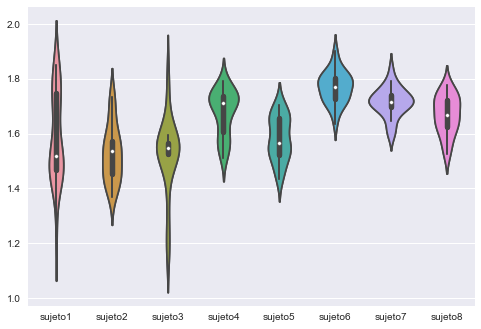

In [92]:
S_entropia = entropia_total(lista_sujetosP, 30)
sn.violinplot(data=S_entropia)
plt.show()

# Dudas y aclaraciones

### Intraelectrodos:
La idea es separar una señal en varias bandas (bins,  buckets), y así quedan tagueadas las muestras en letras, formándose así una cadena de caracteres: ABDCADEDA.
A eso le calculás la entropía, y te dice qué tanta información aporta este electrodo en esa señal (es importante saber qué representa esa señal).

### Interelectrodos:

La idea es tomar varias cadenas de caracteres (ver intraelectrodos), y armar una matriz, donde las filas son los electrodos y las columnas son el tiempo. Luego calculamos entropía para una columna, y vemos cuanta información nos aporta ese tiempo. Finalmente podemos plotear la curva y ver qué momentos de tiempo nos dan la mayor cantidad de información.

### Test estadísticos del c)

Ver los gráficos de violín e inspirarse en ver qué bandas buscar. Una idea al aire es ver qué tan probable es que dos pacientes tengan la misma media de ondas alfa. 